# PyTorch Implementation of a Spiking Neural Network

This notebook aims to provide a simple tutorial on how to implement spiking neural networks in the deep learning framework PyTorch. For more information on PyTorch, see https://pytorch.org/.
The spiking neural network will be implemented from scratch using only features available in basic PyTorch (apart from some simple utils and a package to generate data). The spiking neural network will be trained using gradient descent together with the surrogate gradient descent method to leverage the spiking discontinuities that inevitably arise. You can find more on spiking neural networks under https://neuronaldynamics.epfl.ch/online/. The tutorial requires some prior experience with training artificial neural networks as well as a basic understanding of spiking neural networks.

### Imports
First, we import some packages that are helpful in implementing spiking neural networks.

In [1]:
import os
if not os.path.isfile('snn_utils.py'):
    !wget https://raw.githubusercontent.com/surrogate-gradient-learning/pytorch-lif-autograd/master/snn_utils.py

In [2]:
import numpy as np
import pylab as plt
import tqdm
import snn_utils # very helpful for visualization of SNNs
from utils import make_spike_raster_dataset

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu" # change to 'cpu' if no NVIDIA GPU is available

### Parameters
We start by defining the shape of our neural network. For simplicity, we start only with a couple of fully connected neural networks. Will work with a popular toy dataset where points are sampled from random manifolds, called the "Randman". We embed these d-dimensional manifolds in an n-dimensional space and then sample points from them which serve as
To learn more about random manifolds, look at https://direct.mit.edu/neco/article/33/4/899/97482/The-Remarkable-Robustness-of-Surrogate-Gradient.

In [19]:
N_CLASSES = 2 # Number of classes
N = [16, 32, N_CLASSES] # List of number of neurons per layer
N_EPOCHS = 25 # Number of training epochs
T = 100 # Number of timesteps per epoch
NUM_SAMPLES_PER_CLASS = 1000 
TRAIN_TEST_SPILT = 0.8
NUM_SAMPLES_TRAIN = int(N_CLASSES*NUM_SAMPLES_PER_CLASS*TRAIN_TEST_SPILT)
BATCHSIZE = 48

SEED = 42 
rng = np.random.default_rng(SEED)

### Data Creation

We start by defining a dataloader for our experiment, load the data and split it into a train and a test dataset. The dataset we analyze is called the Random Manifolds or Randman dataset, which consists of d-dimensional manifolds embedded into a n-dimensional space. You can find more about this dataset under https://github.com/fzenke/randman .

In [4]:
class RandmanDataset(Dataset):
    """Characterizes a PyTorch dataset for use with the PyTorch dataloader."""
    def __init__(self, data, labels):
        """Simple initialization of the given dataset."""
        self.data = data
        self.labels = labels

    def __len__(self):
        """Denotes the total number of samples"""
        return len(self.labels)

    def __getitem__(self, index):
        """Retrives a single sample from the given dataset."""
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]

        return X, y

data, labels = make_spike_raster_dataset(rng, nb_classes=N_CLASSES, nb_units=N[0], 
                    nb_steps=T, step_frac=1.0, dim_manifold=2, nb_spikes=1, 
                    nb_samples=NUM_SAMPLES_PER_CLASS, alpha=2.0, shuffle=True)

data_train, labels_train = data[:NUM_SAMPLES_TRAIN], labels[:NUM_SAMPLES_TRAIN]
data_test,  labels_test  = data[NUM_SAMPLES_TRAIN:], labels[NUM_SAMPLES_TRAIN:]

dataset_train = RandmanDataset(data_train, labels_train)
dataset_test = RandmanDataset(data_test, labels_test)

dataloader_train = DataLoader(dataset_train, batch_size=BATCHSIZE, shuffle=True, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCHSIZE, shuffle=True, drop_last=True)

## Model Creation
In this section, we define the various components that are needed to create a differential layer of stateful neurons, such that we are able to construct an arbitrary neural network consisting of fully connected spiking neurons.

### Step Function and Surrogate Gradient Methods
In this section, we create a smooth version of the Heaviside step function $\Theta(x)$ such that the gradient is defined at every point. This surrogate function for the backward pass looks like:
$
\Theta'(x) \equiv \dfrac{1}{(\beta \cdot |x| + 1)^2}
$<br>
This choice of a surrogate gradient is called "superspike" and is quite popular in the neuromorphic computing community. However, the model performance is robust against the actual functional form of the surrogate, see https://direct.mit.edu/neco/article/33/4/899/97482/The-Remarkable-Robustness-of-Surrogate-Gradient.

In [5]:
class SmoothStep(torch.autograd.Function):
    """
    Here, we define a surrogate gradient for the Heaviside step function.
    https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
    """
    @staticmethod
    def forward(aux, x):
        aux.save_for_backward(x)
        return (x >= 0).float() # Behavior similar to Heaviside step function

    def backward(aux, grad_output): # Define the behavior for the backward pass 
        beta = 10.0
        input, = aux.saved_tensors
        surrogate = 1.0/(beta*torch.abs(input) + 1.0)**2
        grad_input = grad_output.clone() * surrogate
        
        return grad_input
    
smooth_step = SmoothStep().apply

### Definition of the Stateful Layer of Spiking Neurons within the Pytorch Framework
Here, we define a new type of layer that inherits from the abstract class nn.Module, such that it can be used like other, ordinary NN layers withing the PyTorch framework. In particular, we have to create buffers for the different state variables of the neurons, i.e. the membrane potential $U$, the current $I$, the recurrent current $I_r$ and the spikes $S$.

In [6]:
class LIFDenseNeuronState(nn.Module):
    """
    Generic module for storing the state of an RNN/SNN.
    We use the buffer function of torch nn.Module to register our
    different states such that PyTorch can manage them.
    """
    def __init__(self, in_channels, out_channels):
        """Simple initialization of the internal states of a LIF population."""
        super(LIFDenseNeuronState, self).__init__()
        self.state_names = ['U', 'I', 'Ir', 'S']
        self.register_buffer('U',torch.zeros(1, out_channels), persistent=True)
        self.register_buffer('I',torch.zeros(1, out_channels), persistent=True)
        self.register_buffer('Ir',torch.zeros(1, out_channels), persistent=True)
        self.register_buffer('S',torch.zeros(1, out_channels), persistent=True)
                                                    
    def update(self, **values):
        """Function to update the internal states."""
        for k, v in values.items():
            setattr(self, k, v) 
    
    def init(self, v=0): 
        """Function that detaches the state/graph across trials."""
        for k in self.state_names:
            state = getattr(self, k)
            setattr(self, k, torch.zeros_like(state)+v)
      

### Definition of the Neuronal Dynamics
The following class defines the dynamics of a layer of spiking neurons according to the leaky integrate-and-fire (LIF) formalism. The differential equations read:<br>
$
\frac{\mathrm{d}U^{(l)}_i}{\mathrm{d}t} = -\frac{1}{\tau_\mathrm{mem}}((U_i^{(l)} - U_\mathrm{rest}) + R(I_i^{(l)} + I_{i,r}^{(l)})) + (U_i^{(l)} - \vartheta)S_i^{(l)}
$

$
\frac{\mathrm{d}I_i^{(l)}}{\mathrm{d}t} = -\frac{I_i^{(l)}}{\tau_\mathrm{syn}} + \sum_j W^{(l)}_{ij} S_j^{(l-1)}
$

$
\frac{\mathrm{d}I_{i, \mathrm{r}}^{(l)}}{\mathrm{d}t} = -\frac{I_{i, \mathrm{r}}^{(l)}}{\tau_\mathrm{syn,r}} + \sum_j V_{ij}^{(l)}S_j^{(l)}
$

Here, $U_i^{(l)}$ is the membrane potential of the $i$th neuron in the layer $l$, $I_i^{(l)}$ is its individual feed-forward input current and $S_i^{(l-1)}$, $S_i^{(l)}$ contain the incoming spikes from the prior layer and emitted spikes form the current layer. 
Thus, the variable $I_{i, \mathrm{r}}^{(l)}$ contains the current coming from recurrent connections within the layer and the weight matrices $W_{ij}^{(l)}$ and $V_{ij}^{(l)}$ contain the weights of the feed-forward and recurrent connections respectively.
The parameters $\tau_\mathrm{mem}$, $\tau_{syn}$ and $\tau_{syn,r}$ are essentially decay constants that control the "leak" of the neurons, while $\vartheta$ and $U_{rest}$ are the spiking threshold and resting potential of the neurons in this layer respectively. 
For more on this topic, see https://arxiv.org/pdf/1901.09948.pdf. <br>
Pytorch by itself is not able to work with differential equations, so we need to discretize them.
They can be discretized using the forward Euler scheme such that we arrive at equations that we can implement into our pytorch layer: <br>
$
U_i^{(l)}[n+1] = \alpha U_i^{(l)}[n] (1 - S_j^{(l)}) + (1 - \alpha) (I_i^{(l)}[n] + I_{i, \mathrm{r}}^{(l)}[n])
$

$
I_i^{(l)}[n+1] = \beta I_i^{(l)}[n] + (1 - \beta) \sum_j W^{(l)}_{ij} S_j^{(l-1)}[n]
$

$
I_{i, \mathrm{r}}^{(l)}[n+1] = \beta_\mathrm{r} I_{i, \mathrm{r}}^{(l)}[n] + (1 - \beta_\mathrm{r}) \sum_j V_{ij}^{(l)}S_j^{(l)}[n]
$

To implement this formula, we make use of the already present nn.Linear layer in pytorch to store the feed-forward and recurrent connection weights. Also, we set the parameters $\vartheta = 1$, $R = 1$ and $U_\mathrm{rest} = 0$.
Note that this definition of the neural dynamics implies that we interpret our spiking neural network as a recurrent neural network, such that when we train it, we will have to use backpropagation through time (BPTT). This makes training spiking neural networks much more resource-demanding than training a compatible artificial neural network.

In [7]:
class LIFDensePopulation(nn.Module):    
    def __init__(self, in_channels, out_channels, alpha = .95, beta=.9, betar=.85, theta=1.0):
        super(LIFDensePopulation, self).__init__()       
        """
        Function to initialize a layer of leaky integrate-and-fire neurons.
        """
        self.fwd_layer = nn.Linear(in_channels, out_channels) # Used to store feed-forward weights
        self.rec_layer = nn.Linear(out_channels, out_channels, bias=False) # Used to store recurrent weights
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.alpha = alpha # Controls decay of membrane potential
        self.beta = beta # Controls decay of feed-forward input current
        self.betar = betar # Controls decay of recurrent input current
        self.theta = theta
        self.state = LIFDenseNeuronState(self.in_channels, self.out_channels)
        
        # lim = (6/(in_channels+out_channels))**0.5
        self.fwd_layer.weight.data.uniform_(-.3, .3) # Initialization of feed-forward layer
        self.rec_layer.weight.data.uniform_(-.0, .0) # Recurrent layer is initialized with zero weights, i.e. ignored
        self.fwd_layer.bias.data.uniform_(-.01, .01) # Initialization of a slight bias current for the fc layer
        
    def forward(self, Sin_t):
        """Forward pass of a batch through the data."""
        state = self.state
        U = self.alpha*(1-state.S.detach())*state.U + (1-self.alpha)*(state.I+state.Ir) # I is weighted by a factor of 20
        I = self.beta*state.I + (1-self.beta)*self.fwd_layer(Sin_t)
        Ir = self.betar*state.Ir + (1-self.betar)*self.rec_layer(state.S)
        S = smooth_step(U-self.theta)
        # Update the neuronal state
        self.state.update(U=U, I=I, Ir=Ir, S=S)
        return self.state
    
    def init_state(self, value=0):
        "Initialize the state variables of this layer."
        self.state.init(value)

### Constructing the Network
This class uses a loop to concstruct multiple layers of fully connected layers of spiking neurons according to the parameters given in the array $N$.

In [8]:
class LIFNetwork(nn.Module):
    def __init__(self, N, alpha=.95, beta=.9, betar=.85, theta=1.0):
        """
        Function to initialize a spiking neural network consisting of multiple 
        layers of spiking neural networks.
        """
        super(LIFNetwork, self).__init__()        
        layers = []
        for i in range(len(N)-1):
            layers.append(LIFDensePopulation(in_channels=N[i],
                                             out_channels=N[i+1],
                                             alpha=alpha,
                                             beta=beta,
                                             betar=betar,
                                             theta=theta))
        self.layers = nn.ModuleList(layers)
    
    def step(self, Sin_t):    
        """
        Perform a single batched forward timestep through the network.
        """
        for layer in self.layers:
            Sin_t = layer(Sin_t).S
        return layer.state # Returns final state of last layer
    
    def forward(self, Sin):
        """Complete batched forward pass through the network."""
        self.init_state()
        for t in range(Sin.shape[0]):
            state = net.step(Sin[t].view(-1, N[0]))
        return state
       
    def init_state(self):
        """Initialize states of the network."""
        for layer in self.layers:
            layer.init_state()

Since all the dynamics are expressed within the PyTorch framework, we are able to simply move the device to a GPU for training, which is usually much faster.

In [9]:
net = LIFNetwork(N).to(device)

The following does optional data-driven initialization to improve learning. This example uses the LSUV (layer-sequential unit variance) initialization from https://arxiv.org/abs/1511.06422. A good initialization is particularly important for spiking neural networks to make sure that we have a balance between the spiking count of all the neurons and no quiescent neurons.

In [24]:
from utils import forward_layer, torch_init_LSUV
data, target = next(iter(dataloader_train))
data_flat =  data.transpose(0,1).to(device).view(T,BATCHSIZE,-1)
torch_init_LSUV(net, data_flat, tgt_mu=-0.75) 

Layer: 0, Variance: 6.12e-05, Mean U: -0.0024, Mean S: 0.0
Layer: 1, Variance: 0.0, Mean U: 0.0, Mean S: 0.0
Layer: 0, Variance: 0.00612, Mean U: -0.172, Mean S: 0.0
Layer: 1, Variance: 2.22e-16, Mean U: -0.148, Mean S: 0.0
Layer: 0, Variance: 0.539, Mean U: -0.552, Mean S: 0.0
Layer: 1, Variance: 0.313, Mean U: -0.202, Mean S: 0.0
Layer: 0, Variance: 0.915, Mean U: -0.74, Mean S: 0.0013
Layer: 1, Variance: 1.47, Mean U: -0.702, Mean S: 0.0
Layer: 0, Variance: 0.915, Mean U: -0.74, Mean S: 0.0013
Layer: 1, Variance: 1.14, Mean U: -0.566, Mean S: 0.0292
Layer: 0, Variance: 0.915, Mean U: -0.74, Mean S: 0.0013
Layer: 1, Variance: 1.02, Mean U: -0.569, Mean S: 0.00833
Layer: 0, Variance: 0.915, Mean U: -0.74, Mean S: 0.0013
Layer: 1, Variance: 1.04, Mean U: -0.592, Mean S: 0.00417
Layer: 0, Variance: 0.915, Mean U: -0.74, Mean S: 0.0013
Layer: 1, Variance: 1.08, Mean U: -0.607, Mean S: 0.0125
Layer: 0, Variance: 0.915, Mean U: -0.74, Mean S: 0.0013
Layer: 1, Variance: 1.07, Mean U: -0.635

## Learning Setup

Since we are working on a classification task, it makes sense to use a cross-entropy loss to train the model. The output of the model is typically a sequence of frames containing zeros and ones to indicate whether a neuron has spiked at a certain timestep. These spikes are then summed up and we apply a softmax for them to get a probability distribution for the different classes. Thus output neuron that spiked the most gives the highest probability for the corresponding class. Encoding information in this way is called rate-coding/spike count. Furthermore we will use an ADAM optimizer to adjust the weights.

In [25]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=2e-2) #, momentum=0.9) # , betas=[0., .95]) 

In this programming block, we define the training loop for our spiking neural network. As we have provided a proper gradient for the spiking discontinuities, we can train our model using gradient descent and all the other features that are available in PyTorch.

In [26]:
pbar = tqdm.trange(N_EPOCHS)
for epoch in pbar: 
    loss = 0
    acc = []
    # Test loop
    for Sin, target in dataloader_test: 
        Sin = Sin.to(device).transpose(0,1)
        target = target.to(device)
        with torch.no_grad(): # Do not change weights during testing
            state = net(Sin)
            tgt = target.cpu().numpy()
            pred = state.S.clone().cpu().numpy()
            acc.append(np.mean(np.argmax(pred, axis=1)==tgt))
    # Training loop
    for Sin, target in dataloader_train:
        Sin = Sin.to(device).transpose(0,1)
        target = target.to(device).long() # PyTorch loss function requires Long-type
        state = net(Sin)
        loss_seq = loss_fn(state.S, target)
        loss_seq.backward()
        opt.step()
        opt.zero_grad()
        loss += loss_seq

    pbar.set_description("Training Loss {0} | Accuracy {1:2.2%}: | " .format(loss,np.mean(acc)))

Training Loss 85.9803237915039 | Accuracy 82.08%: | : 100%|███████████████████████████████████████████████████████████████████| 35/35 [04:51<00:00,  8.34s/it]


## Probe and plot final layer states

To get some intuition about how the different layers behave, we can take a look at the evolution of the membrane potential and the spiking behavior of the output neurons by analyzing a single sample.

In [14]:
Uprobe = np.empty([BATCHSIZE,T,N[-1]])
Iprobe = np.empty([BATCHSIZE,T,N[-1]])
Sprobe = np.empty([BATCHSIZE,T,N[-1]])
for t in range(T):
    state = net(data_flat[t].cuda())
    Uprobe[:,t] = state.U.clone().data.cpu().numpy()
    Iprobe[:,t] = state.I.clone().data.cpu().numpy()
    Sprobe[:,t] = state.S.clone().data.cpu().numpy()

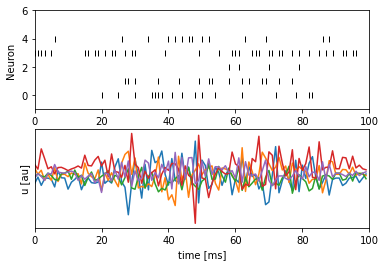

In [15]:
snn_utils.plotLIF(U=Iprobe[0], S=Sprobe[0], staggering = .2);